<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/11_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Deployment

In [6]:
# torch 1.12+ ve torchvision 0.13+ √ºzeri olmalƒ±
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version 1.12+ √ºzeri olmalƒ±"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision 0.13+ √ºzeri olmalƒ±"
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision en g√ºncel s√ºr√ºm√º ile y√ºkleniyor...")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Trochinfo Kurulumu
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulunamadƒ±, y√ºkleniyor...")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlƒ± dosyalar
    print("[INFO] Github dosyalarƒ± indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ƒ±
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] torch/torchvision en g√ºncel s√ºr√ºm√º ile y√ºkleniyor...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#VERƒ∞LERƒ∞ ALMA ƒ∞≈ûLEMƒ∞
# pizza, steak, sushi images from GitHub by mrdbourke
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# ƒ∞ndirilen verileri yerle≈ütirme i≈ülemi
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


##EffNetB2 ve ViT Modellerini Daƒüƒ±tƒ±ma Hazƒ±rlama

###EffNetB2‚Äôyi Hazƒ±rlama

In [8]:
# 1. EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Modeli Hazƒ±rlama
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # weights="DEFAULT"

# 4. Temel Katmanlarƒ± Model ƒ∞√ßinde Dondurma
for param in effnetb2.parameters():
    param.requires_grad = False

# EffNetB2 Sƒ±nƒ±f Ba≈ülƒ±klarƒ±nƒ± Yazdƒ±ralƒ±m.
print(effnetb2.classifier)

# 5.Sƒ±nƒ±f Ba≈ülƒ±klarƒ±nƒ± G√ºncelleme
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), #dropout
    nn.Linear(in_features=1408, # girdiler
              out_features=3)) # √ßƒ±ktƒ±larƒ±mƒ±z (Sƒ±nƒ±f ba≈ülƒ±klarƒ±)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)


In [9]:
#EffnetB2 Modeli Olu≈üturma
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    # 1, 2, 3. EffNetB2 eƒüitilmi≈ü weights, transforms ve model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Temel Katmanlarƒ± Dondurma
    for param in model.parameters():
        param.requires_grad = False

    # 5. Tekrarlanabilirlik i√ßin sƒ±nƒ±flandƒ±rma ba≈ülƒ±ƒüƒ±nƒ± rastgele seed atma
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)
from torchinfo import summary

# EffNetB2 modelini yazdƒ±ralƒ±m.
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
‚îú‚îÄSequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
‚îÇ    ‚îî‚îÄConv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
‚îÇ    ‚îÇ    ‚îî‚îÄConv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
‚îÇ    ‚îÇ    ‚îî‚îÄBatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
‚îÇ    ‚îÇ    ‚îî‚îÄSiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
‚îÇ    ‚îî‚îÄSequential (1)                          

In [10]:
#DataLoaders
from Module_Files import data_setup
from Module_Files import engine

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Loss fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss()

# Seed Atƒ±p Sonu√ßlarƒ± Yazdƒ±rma
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


[INFO] Modelin Kaydedildiƒüi Yer: models/09_effnetb2_pizza_steak_sushi_20_percent.pth


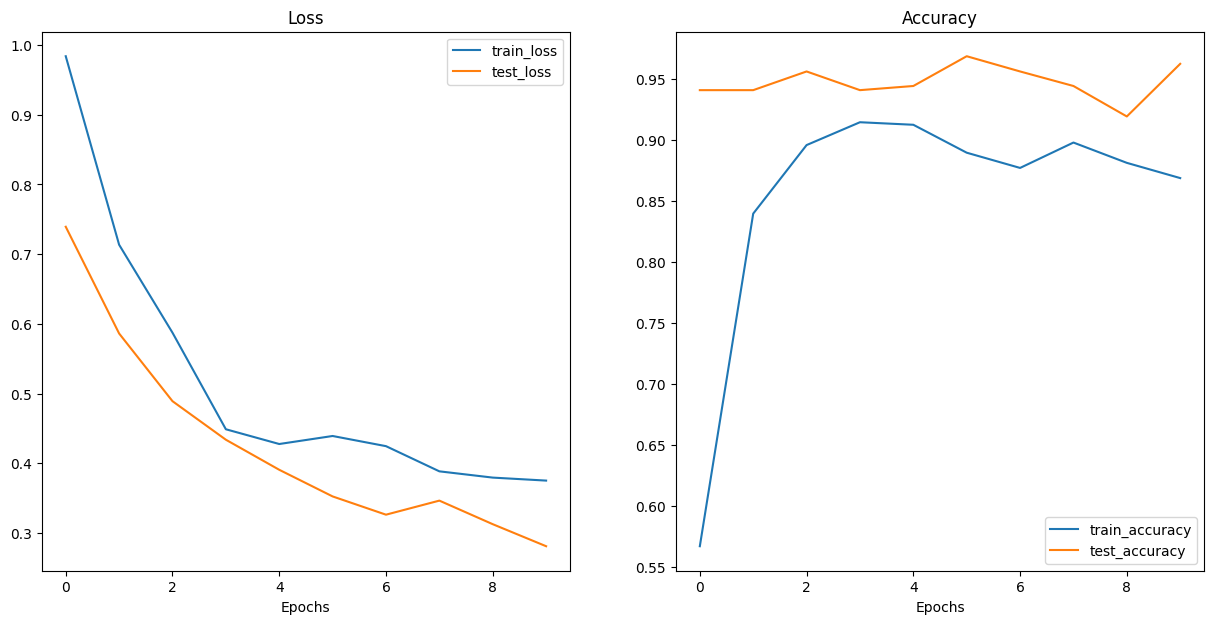

In [11]:
from helper_functions import plot_loss_curves
from Module_Files import utils

# Modeli Kaydetme
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_pizza_steak_sushi_20_percent.pth")

plot_loss_curves(effnetb2_results)

In [12]:
from pathlib import Path

# Baytlƒ±k veriyi megabayt yaptƒ±k.
pretrained_effnetb2_model_size = Path("models/09_effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Eƒüitilmi≈ü EffNetB2 Modeli Boyutu: {pretrained_effnetb2_model_size} MB")

# EffNetB2 Parametre Sayƒ±sƒ±
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(effnetb2_total_params)

# EffNetB2 ƒ∞statistiksel Veri
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
print(effnetb2_stats)

Eƒüitilmi≈ü EffNetB2 Modeli Boyutu: 29 MB
7705221
{'test_loss': 0.28108686208724976, 'test_acc': 0.9625, 'number_of_parameters': 7705221, 'model_size (MB)': 29}


###ViT-B/16 Modelini Hazƒ±rlama

In [13]:
# ViT Hazƒ±r Model
vit = torchvision.models.vit_b_16()
print(vit.heads)

#ViT Modelini Fonksiyon Olarak Tasarlayalƒ±m
def create_vit_model(num_classes:int=3,
                     seed:int=42):

    # ViT_B_16 eƒütilmi≈ü weights, transforms ve model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Dondurulmu≈ü Katmanlar
    for param in model.parameters():
        param.requires_grad = False

    # Ba≈ülƒ±klar hazƒ±r bir ≈üekilde seed atma
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # orijinal modeldeki deƒüer
                                          out_features=num_classes)) # 3 sƒ±nƒ±f √ßƒ±ktƒ±mƒ±zƒ±n deƒüeri

    return model, transforms


# ViT model ve transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

from torchinfo import summary

# ViT modelini yazdƒ±ralƒ±m.
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 330M/330M [00:04<00:00, 71.2MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
‚îú‚îÄConv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
‚îú‚îÄEncoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
‚îÇ    ‚îî‚îÄDropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
‚îÇ    ‚îî‚îÄSequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
‚îÇ    ‚îÇ    ‚îî‚îÄEncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
‚îÇ    ‚îÇ    ‚îî‚îÄEncoderBlock (encoder_layer_1)         

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
[INFO] Modelin Kaydedildiƒüi Yer: models/09_vit_pizza_steak_sushi_20_percent.pth
Eƒüitilmi≈ü ViT Modeli Boyut

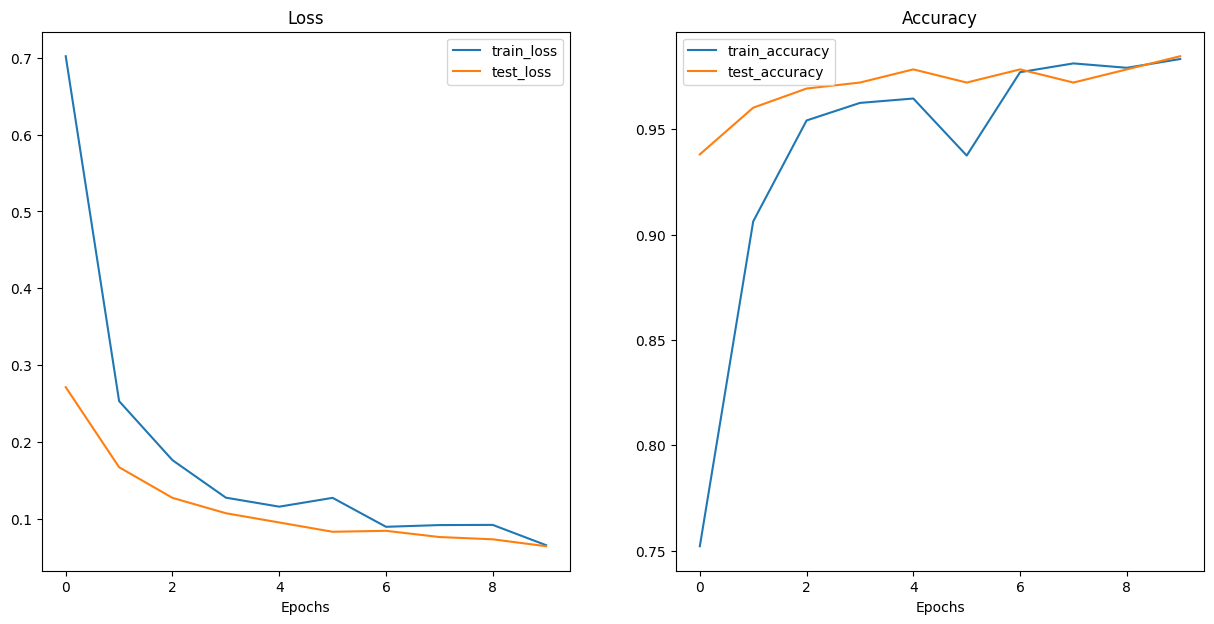

In [14]:
#ViT DataLoaders
from Module_Files import data_setup
from Module_Files import engine
from Module_Files import utils
from pathlib import Path
from helper_functions import plot_loss_curves

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Loss Fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss()

# ViT model ve seeds
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

plot_loss_curves(vit_results)

# Modeli Kaydet
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_pizza_steak_sushi_20_percent.pth")

# byt'larƒ± Megabayt yapalƒ±m
pretrained_vit_model_size = Path("models/09_vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Eƒüitilmi≈ü ViT Modeli Boyutu: {pretrained_vit_model_size} MB")

# ViT Parametre Sayƒ±sƒ±
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
print(vit_total_params)

# ViT ƒ∞statistiklerini Yazdƒ±ralƒ±m
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

print(vit_stats)

##Modellere Zamanlamaya Baƒülƒ± Olarak Tahminler Y√ºr√ºtt√ºrme

###EffNetB2 Modelinin ƒ∞ncelenmesi

In [15]:
from pathlib import Path

# B√ºt√ºn Veri Yollarƒ±nƒ± alalƒ±m
print(f"[INFO] '.jpg' ile biten b√ºt√ºn dosyalarƒ± al: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Tahminleri ve sonu√ßlarƒ± yazdƒ±ran bir fonksiyon yazalƒ±m.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Bo≈ü liste olu≈üturalƒ±m
    pred_list = []

    # 3. Dosyalardaki deƒüerlerin hepsini veri olarak ele alacaƒüƒ±z.
    for path in tqdm(paths):

        # 4. Her √∂rneklem i√ßin bri veri seti olu≈üturacaƒüƒ±z.
        pred_dict = {}

        # 5. √ñrneƒüin yolunu, sƒ±nƒ±f adƒ±nƒ± yazalƒ±m.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Zamanlayƒ±cƒ± ba≈ülat.
        start_time = timer()

        # 7. Resim yolunu a√ß.
        img = Image.open(path)

        # 8. Cihaza resmi yolla (batch miktarƒ± vs. i√ßerikleri ayarla)
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Modeli cihaza yolla.
        model.to(device)
        model.eval()

        # 10. Tahmin olasƒ±lƒ±ƒüƒ±nƒ±, tahmin etiketini ve tahmin sƒ±nƒ±fƒ±nƒ± alƒ±n
        with torch.inference_mode():
            pred_logit = model(transformed_image) # hedef √∂rneklem √ºzerinde √ßƒ±karƒ±m ger√ßekle≈ütirme
            pred_prob = torch.softmax(pred_logit, dim=1) # logitleri tahmin olasƒ±lƒ±klarƒ±na d√∂n√º≈üt√ºr
            pred_label = torch.argmax(pred_prob, dim=1) # tahmin olasƒ±lƒ±klarƒ±nƒ± tahmin etiketine d√∂n√º≈üt√ºr
            pred_class = class_names[pred_label.cpu()] # CPU'da olmasƒ± gereken sabit kodlu tahmin sƒ±nƒ±fƒ±

            # 11. S√∂zl√ºkteki ≈üeylerin CPU'da olduƒüuna bakƒ±yoruz.
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. Zamanlayƒ±cƒ±yƒ± kapat ve her bir tahmini zamanlayƒ±cƒ± ile yazdƒ±r
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Tahminler Etiketle e≈üle≈üiyor mu bakalƒ±m.
        pred_dict["correct"] = class_name == pred_class

        # 14. Listeye Sonu√ßlarƒ± yazdƒ±ralƒ±m.
        pred_list.append(pred_dict)

    # 15. Listeyi sonu√ß olarak d√∂n√ºrelim.
    return pred_list

[INFO] '.jpg' ile biten b√ºt√ºn dosyalarƒ± al: data/pizza_steak_sushi_20_percent/test


In [16]:
# EffNetB2 Tahminlerini Yazdƒ±r
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") #CPU
# √áƒ±ktƒ±daki ilk iki veriyi yazdƒ±ralƒ±m:
print(effnetb2_test_pred_dicts[:2])

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'), 'class_name': 'pizza', 'pred_prob': 0.9278, 'pred_class': 'pizza', 'time_for_pred': 0.15, 'correct': True}, {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'), 'class_name': 'pizza', 'pred_prob': 0.8625, 'pred_class': 'pizza', 'time_for_pred': 0.1009, 'correct': True}]


In [17]:
# DataFrame ile sonu√ßlarƒ± yazdƒ±rma
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/pizza/2...      pizza     0.9278   
1  data/pizza_steak_sushi_20_percent/test/pizza/6...      pizza     0.8625   
2  data/pizza_steak_sushi_20_percent/test/pizza/2...      pizza     0.9468   
3  data/pizza_steak_sushi_20_percent/test/pizza/6...      pizza     0.6250   
4  data/pizza_steak_sushi_20_percent/test/pizza/4...      pizza     0.7921   

  pred_class  time_for_pred  correct  
0      pizza         0.1500     True  
1      pizza         0.1009     True  
2      pizza         0.1139     True  
3      pizza         0.1036     True  
4      pizza         0.0984     True

In [18]:
# Doƒüru sonu√ßlarƒ± kontrol edelim.
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [19]:
# Her tahmindeki ortalama s√ºreyi yazdƒ±ralƒ±m.
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 her tahmindeki ortalama s√ºre: {effnetb2_average_time_per_pred} saniye s√ºrd√º.")

EffNetB2 her tahmindeki ortalama s√ºre: 0.1024 saniye s√ºrd√º.


In [20]:
# EffNetB2 ortalama tahmin s√ºresini yazdƒ±ralƒ±m.
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1024}

###ViT-B/16 Modelinin ƒ∞ncelenmesi

In [21]:
# ViT modelni hazƒ±rlama
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

# DataFrame ile Sonu√ßlarƒ± Yazdƒ±ralƒ±m.
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()


  0%|          | 0/150 [00:00<?, ?it/s]

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/pizza/2...      pizza     0.9974   
1  data/pizza_steak_sushi_20_percent/test/pizza/6...      pizza     0.9969   
2  data/pizza_steak_sushi_20_percent/test/pizza/2...      pizza     0.9983   
3  data/pizza_steak_sushi_20_percent/test/pizza/6...      pizza     0.9855   
4  data/pizza_steak_sushi_20_percent/test/pizza/4...      pizza     0.9917   

  pred_class  time_for_pred  correct  
0      pizza         0.7239     True  
1      pizza         0.4088     True  
2      pizza         0.3698     True  
3      pizza         0.3901     True  
4      pizza         0.3889     True

In [22]:
# Doƒüru sonu√ß deƒüerlerini yazdƒ±ralƒ±m.
vit_test_pred_df.correct.value_counts()


correct
True     148
False      2
Name: count, dtype: int64

In [23]:
# Her tahmindeki ortalama s√ºreyi yazdƒ±ralƒ±m.
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

# ViT modelinin ortalama tahmin s√ºresini yazdƒ±ralƒ±m.
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred

ViT average time per prediction: 0.3998 seconds


##Modellerdeki Sonu√ßlarƒ±, Tahminleri ve Boyutlarƒ± Kar≈üƒ±la≈ütƒ±rma

In [24]:
# DataFrame'de ƒ∞ki Sonucu Yazdƒ±ralƒ±m.
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Model isimlerine g√∂re  s√ºtunlar olu≈üturalƒ±m.
df["model"] = ["EffNetB2", "ViT"]

# Tutarlƒ±lƒ±klarƒ± y√ºzdelik yapalƒ±m.
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

test_loss  test_acc  number_of_parameters  model_size (MB)  \
0   0.281087     96.25               7705221               29   
1   0.064435     98.47              85800963              327   

   time_per_pred_cpu     model  
0             0.1024  EffNetB2  
1             0.3998       ViT

In [25]:
# ViT ve EffNetB2 karakteristik sonu√ßlarƒ±na bakalƒ±m
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

test_loss  test_acc  number_of_parameters  \
ViT to EffNetB2 ratios   0.229233  1.023065             11.135432   

                        model_size (MB)  time_per_pred_cpu  
ViT to EffNetB2 ratios        11.275862           3.904297

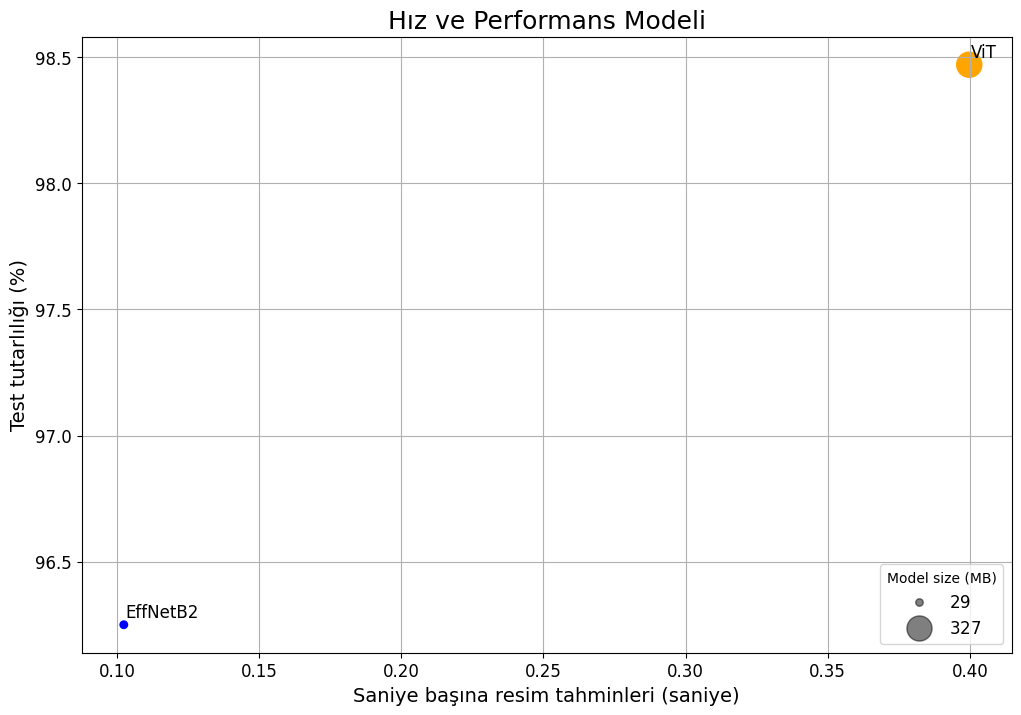

In [26]:
# 1. DataFrame i√ßin plot olu≈üturalƒ±m
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # renk se√ßimi
                     s="model_size (MB)") # model boyutuna g√∂re noktalarƒ±n b√ºy√ºkl√ºƒü√º

# 2. Grtafiƒüin renkleri isimleri vs.
ax.set_title("Hƒ±z ve Performans Modeli", fontsize=18)
ax.set_xlabel("Saniye ba≈üƒ±na resim tahminleri (saniye)", fontsize=14)
ax.set_ylabel("Test tutarlƒ±lƒ±ƒüƒ± (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Model ƒ∞simleri
for index, row in df.iterrows():
    ax.annotate(text=row["model"], xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03), size=12)

# 4. Model Boyutlarƒ±nƒ±n yazdƒ±rƒ±lmasƒ±
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# G√∂rseli saklama
!mkdir images/

plt.savefig("images/09-speed-vs-performance.jpg")

# G√∂rseli g√∂ster
plt.show()

##Gradio Demosunu Hazƒ±rlama

In [27]:
#Gradio Kurulumu
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.3/62.3 MB 16.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 322.0/322.0 kB 27.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12.6/12.6 MB 64.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 71.5/71.5 kB 6.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.3/62.3 kB 5.8 MB/s eta 0:00:00
Gradio version: 5.17.1


In [28]:
# EffNetB2 CPU'da √áalƒ±≈üsƒ±n
effnetb2.to("cpu")

# Kontrol edelim.
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [29]:
from typing import Tuple, Dict

#Gelen resmi zaman ag√∂re etiketleme i≈ülemi yapƒ±lacak.
def predict(img) -> Tuple[Dict, float]:

    # Zamanlayƒ±cƒ± ba≈ülat.
    start_time = timer()

    # Resmi Transforma ekle ve batch boyutu at.
    img = effnetb2_transforms(img).unsqueeze(0)

    # Modele gelen resmi yolla
    effnetb2.eval()
    with torch.inference_mode():
        # Modeldeki resmin olasƒ±lƒ±klarƒ±nƒ± deƒüi≈ükene aktar.
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Resmin sƒ±nƒ±flardan hangisine ait olduƒüuna dair tahminleri ve s√ºreleri al
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # tahmin s√ºresini yaz.
    pred_time = round(timer() - start_time, 5)

    # sonu√ßlarƒ± d√∂nd√ºr (etiket ve tahmin)
    return pred_labels_and_probs, pred_time

In [30]:
import random
from PIL import Image

# Klas√∂rdeki resimleri al
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Rastgele resim se√ß i√ßinden
random_image_path = random.sample(test_data_paths, k=1)[0]

# resmi a√ß
image = Image.open(random_image_path)
print(f"[INFO] Tahmin y√ºr√ºt√ºlen resim: {random_image_path}\n")

# resmi fonksiyons sok.
pred_dict, pred_time = predict(img=image)
print(f"Tahmin ve Olasƒ±lƒ±ƒüƒ±: \n{pred_dict}")
print(f"Tahmin S√ºresi: {pred_time} saniye")

[INFO] Tahmin y√ºr√ºt√ºlen resim: data/pizza_steak_sushi_20_percent/test/steak/100274.jpg

Tahmin ve Olasƒ±lƒ±ƒüƒ±: 
{'pizza': 0.22663846611976624, 'steak': 0.382261723279953, 'sushi': 0.39109984040260315}
Tahmin S√ºresi: 0.13953 saniye


In [31]:
# Gradio demosu resim test dosyasƒ±
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg']]

In [32]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini üçïü•©üç£"
description = "EfficientNetB2 modeli resmin pizza, biftek veta su≈üi olup olmadƒ±ƒüƒ±nƒ± kontrol ediyor. (mrdbourke tarafƒ±ndan hazƒ±rlandƒ±)"
article = "ƒ∞lham Alƒ±nan √áalƒ±≈üma: [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Gradio Demosu
demo = gr.Interface(fn=predict, # girdi ve √ßƒ±ktƒ±yƒ± ayarlayan temel fonksiyon
                    inputs=gr.Image(type="pil"), # girdilerimiz
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # √ßƒ±ktƒ±larƒ±mƒ±z
                             gr.Number(label="Prediction time (s)")], # predict fonksiyonu iki deƒüer d√∂nd√ºr√ºyor
                    examples=example_list, #Veri listemiz
                    title=title, #Ba≈ülƒ±k
                    description=description, #A√ßƒ±klamalar
                    article=article) #√áalƒ±≈ümanƒ±n nereden alƒ±ndƒ±ƒüƒ±nƒ± yayƒ±nlama

# Demo'yu sunma
demo.launch(debug=False, # Hata varsa yazdƒ±r.
            share=True) # Halka a√ßƒ±k bir payla≈üƒ±m yap.

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://950543b52d8cf9c4bf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
#√áƒ±ktƒ± olarak bir demo √ºretme
import shutil
from pathlib import Path

# FoodVision mini demo Dosya Yolu
foodvision_mini_demo_path = Path("demo/foodvision_mini/")

# Varsa √∂nceki dosyalarƒ± sil ve yenisini olu≈ütur.
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# Eƒüer dosya yoksa olu≈ütur.
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Klas√∂r√ºn i√ßindekileri kontrol et.
!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


In [34]:
#√ñrneklerimizi Klas√∂re Y√ºkleyelim.
import shutil
from pathlib import Path

# 1. √ñrnekler dosya yolunu demo klas√∂r√ºn√ºn i√ßinde olu≈üturalƒ±m
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. 3 rastgele resim se√ßelim.
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. 3 √∂rnek resmin kopyasƒ±nƒ± g√∂melim.
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demo/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demo/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demo/foodvision_mini/examples/2582289.jpg


In [35]:
import os

# √ñrnekleri Gradio'da kullanmak i√ßin liste haline getirelim.
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [36]:
#Mdeoli Demo Klas√∂r√ºne Ekleme
import shutil

# Modelin kaynak dosya yolunu alƒ±yoruz.
effnetb2_foodvision_mini_model_path = "models/09_effnetb2_pizza_steak_sushi_20_percent.pth"

# Modelin kopyaanacaƒüƒ±z klas√∂r√º buluyoruz.
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Klas√∂re modeli ta≈üƒ±yalƒ±m.
try:
    print(f"[INFO] Model bu klas√∂re: {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination} ta≈üƒ±ndƒ±.")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Modelin ta≈üƒ±nmasƒ± bitti.")

# Eƒüer model ta≈üƒ±nmƒ±≈üsa bak.
except:
    print(f"[INFO] Model bulunamadƒ±: {effnetb2_foodvision_mini_model_path}, √∂nceden ta≈üƒ±nmƒ±≈ü olabilir mi?")
    print(f"[INFO] Model klas√∂rde bulundu: {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Model bu klas√∂re: models/09_effnetb2_pizza_steak_sushi_20_percent.pth to demo/foodvision_mini/09_effnetb2_pizza_steak_sushi_20_percent.pth ta≈üƒ±ndƒ±.
[INFO] Modelin ta≈üƒ±nmasƒ± bitti.


In [37]:
%%writefile demo/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

#Modelin √ßalƒ±≈üma fonksiyonu
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """EfficientNetB2 aracƒ±nƒ±n tasarƒ±mƒ±

    Args:
        num_classes (int, optional): sƒ±nƒ±f yani √ºr√ºn √ßƒ±ktƒ± t√ºrlerimiz burada.
            en y√ºksek deƒüer 3't√ºr.
        seed (int, optional): reastgele seed atƒ±yor. Seed deƒüeri 42.

    Returns:
        model (torch.nn.Module): EffNetB2
        transforms (torchvision.transforms): EffNetB2 resim transform.
    """
    # EffNetB2 eƒütilmi≈ü weights, transforms ve model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # T√ºm temel katmanlarƒ± dondurulmu≈ü model
    for param in model.parameters():
        param.requires_grad = False

    # Ba≈ülƒ±klarƒ±n deƒüi≈ütirildiƒüi ve seed atƒ±ldƒ±ƒüƒ± veri seti
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demo/foodvision_mini/model.py


In [38]:
%%writefile demo/foodvision_mini/app.py
### 1. Sƒ±nƒ±flarƒ± ve k√ºt√ºphaneleri ekleme ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# sƒ±nƒ±f isimlerini belirleme
class_names = ["pizza", "steak", "sushi"]

### 2. Model ve transform hazƒ±rlama ###

# EffNetB2 modelini olu≈ütur
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names),
)

# weight kaydet
effnetb2.load_state_dict(
    torch.load(
        f="09_effnetb2_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # CPU
    )
)

### 3. Tahmin Fonksiyonu ###
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Zamanlayƒ±cƒ±yƒ± ba≈ülat.
    start_time = timer()

    # Resmi ekle ve batch boyutu a√ß.
    img = effnetb2_transforms(img).unsqueeze(0)

    # Modeli √ßalƒ±≈ütƒ±r.
    effnetb2.eval()
    with torch.inference_mode():
        # Modeldeki resmin olasƒ±lƒ±klarƒ±nƒ± deƒüi≈ükene aktar.
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    #Resmin sƒ±nƒ±flardan hangisine ait olduƒüuna dair tahminleri ve s√ºreleri al
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Tahmin S√ºresini hesapla
    pred_time = round(timer() - start_time, 5)

    # etiketleri ve s√ºreyi yeniden hesapla.
    return pred_labels_and_probs, pred_time

### 4. Gradio Uygulamasƒ± (Aray√ºz) ###

# Ba≈ülƒ±k vs. i√ßerik bilgisini olu≈ütur.
# Create title, description and article strings
title = "FoodVision Mini üçïü•©üç£"
description = "EfficientNetB2 modeli resmin pizza, biftek veta su≈üi olup olmadƒ±ƒüƒ±nƒ± kontrol ediyor (mrdbourke tarafƒ±ndan hazƒ±rlandƒ±). Ben Uƒüur Sƒ±rvermez eƒüitim ama√ßlƒ±, konuyu √∂ƒürenmek i√ßin b√ºt√ºn bunlarƒ± tekrar hazƒ±rladƒ±m."
article = "ƒ∞lham Alƒ±nan √áalƒ±≈üma: [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# "examples/" yolundan √∂rnekleri getir.
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Gradio Demosu
demo = gr.Interface(fn=predict, # girdi ve √ßƒ±ktƒ±yƒ± ayarlayan temel fonksiyon
                    inputs=gr.Image(type="pil"), # girdilerimiz
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # √ßƒ±ktƒ±larƒ±mƒ±z
                             gr.Number(label="Prediction time (s)")], # predict fonksiyonu iki deƒüer d√∂nd√ºr√ºyor
                    examples=example_list, #Veri listemiz
                    title=title, #Ba≈ülƒ±k
                    description=description, #A√ßƒ±klamalar
                    article=article) #√áalƒ±≈ümanƒ±n nereden alƒ±ndƒ±ƒüƒ±nƒ± yayƒ±nlama

# Demo'yu sunma
demo.launch()

Writing demo/foodvision_mini/app.py


In [39]:
%%writefile demo/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demo/foodvision_mini/requirements.txt


In [40]:
!ls demo/foodvision_mini

# foodvision_mini klas√∂r√ºn√º sƒ±kƒ±≈ütƒ±rƒ±p sadece belirli dosyalarƒ± almak i√ßin yazdƒ±k.
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# FoodVision Mini Demo indirme
try:
    from google.colab import files
    files.download("demo/foodvision_mini.zip")
except:
    print("Google Colab'da √ßalƒ±≈ümƒ±yor, google.colab.files.download() kullanƒ±lamƒ±yor, l√ºtfen manuel olarak indirin.")

09_effnetb2_pizza_steak_sushi_20_percent.pth  app.py  examples	model.py  requirements.txt
  adding: 09_effnetb2_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 50%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: model.py (deflated 50%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
# IPython Python'ƒ± interaktif yapan bir k√ºt√ºphanedir
from IPython.display import IFrame

# FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/ugursirvermez/ugursirvermez/FoodVisionMiniDemo", width=900, height=750)